In [11]:
import numpy as np
from spyderwebb import ann

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

In [51]:

jw=ann.JWSTANNModel()
sp=jw({'teff':4000.0,'logg':2.0,'cm':0.1})

In [4]:
%timeit jw({'teff':4000.0,'logg':2.0,'cm':0.1})

1.04 ms ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
%timeit  jw({'teff':4000.2,'logg':2.0,'cm':0.1})

1 ms ± 54.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


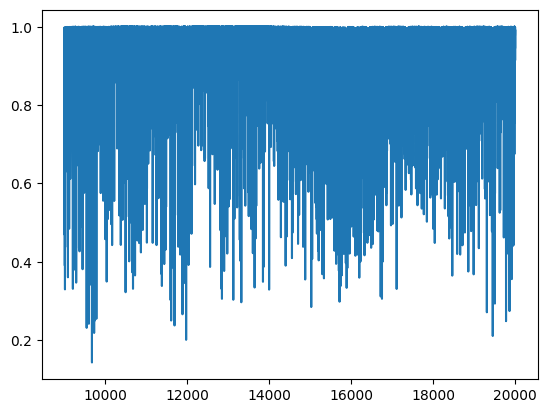

In [46]:
sp.plot()
#plt.xlim(9000, 9100)

In [24]:
ann??

Type:        module
String form: <module 'spyderwebb.ann' from '/usr/local/lib/python3.11/site-packages/spyderwebb/ann.py'>
File:        /usr/local/lib/python3.11/site-packages/spyderwebb/ann.py
Source:     
import os
import copy
import time
import numpy as np
import traceback
from astropy.table import Table
from scipy.optimize import curve_fit
from theborg.emulator import Emulator
from doppler.spec1d import Spec1D
from . import utils

cspeed = 2.99792458e5  # speed of light in km/s

class JWSTANNModel():

    # Model JWST nirspec spectra using ANN model
    
    def __init__(self,spobs=None,loggrelation=False,verbose=False):
        # Load the ANN models
        emwarm = Emulator.read(utils.datadir()+'ann_28pars_warm.pkl')
        emcool = Emulator.read(utils.datadir()+'ann_28pars_cool.pkl')
        self._models = [emcool,emwarm]
        self.nmodels = len(self._models)
        self.labels = self._models[0].label_names
        self.nlabels = len(self.labels)
        self._ranges = np.

In [28]:
from theborg.emulator import Emulator
from spyderwebb import utils as spyu

class ReDispJWSTANNModel(ann.JWSTANNModel):
    def __init__(self,spobs=None,loggrelation=False,verbose=False):
        # Load the ANN models
        emwarm = Emulator.read(spyu.datadir()+'ann_28pars_warm.pkl')
        emcool = Emulator.read(spyu.datadir()+'ann_28pars_cool.pkl')
        self._models = [emcool,emwarm]
        self.nmodels = len(self._models)
        self.labels = self._models[0].label_names
        self.nlabels = len(self.labels)
        self._ranges = np.zeros((self.nmodels,self.nlabels,2),float)
        for i in range(self.nmodels):
            for j in range(self.nlabels):
                self._ranges[i,j,:] = [np.min(self._models[i].training_labels[:,j]),
                                       np.max(self._models[i].training_labels[:,j])]
        self._ranges[0,0,1] = 4100.0
        self._ranges[1,0,0] = 4100.0        
        self.ranges = np.zeros((self.nlabels,2),float)
        self.ranges[0,:] = [self._ranges[0,0,0],self._ranges[1,0,1]]
        for i in np.arange(1,self.nlabels):
            self.ranges[i,:] = [np.max(self._ranges[:,i,0]),np.min(self._ranges[:,i,1])]
        
        # Alpha element index
        alphaindex = []
        for i,l in enumerate(self.labels):
            if l in ['om','cam','mgm','tim','sm','sim']:
                alphaindex.append(i)
        self._alphaindex = np.array(alphaindex)
        
        # Input observed spectrum information
        self._spobs = spobs
            
        # ANN model wavelengths
        npix_model = 22001
        self._dispersion = np.arange(npix_model)*0.5+9000

        # Get logg label
        loggind, = np.where(np.char.array(self.labels).lower()=='logg')
        if len(loggind)==0:                
            raise ValueError('No logg label')
        self.loggind = loggind[0]
        
        # Load the ANN model for logg-relationship
        logg_model = Emulator.load(spyu.datadir()+'apogeedr17_rgb_logg_ann.npz')
        self.logg_model = logg_model
        
        self.loggrelation = loggrelation
        self.verbose = verbose
        self.fitparams = None
        self.njac = 0

j2 = ReDispJWSTANNModel()
j2({'teff':4000.0,'logg':2.0,'cm':0.1})

ValueError: Wave and Flux array sizes do not match

In [35]:
m = j2._models[0]

In [44]:
m(j2.mklabels({'teff':4000.0,'logg':2.0,'cm':0.1})).shape

(22001,)